# Gendist V1.0

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import jax
import optax
import dojax
import pickle
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from augly import image
from sklearn.decomposition import PCA
from datetime import datetime
from flax import serialization
from multiprocessing import Pool
from loguru import logger

In [3]:
from tqdm.notebook import tqdm

In [4]:
import gendist
from gendist import training, processing

In [5]:
from gendist.models import MLPDataV1
from gendist.processing import flat_and_concat_params
from gendist.training import TrainingConfig, make_cross_entropy_loss_func

In [6]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [7]:
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root=".", train=False, download=True)

In [8]:
n_classes = 10
X_train = np.array(mnist_train.data)
y_train = np.array(mnist_train.targets)
y_train_ohe = jax.nn.one_hot(y_train, n_classes)

In [9]:
key = jax.random.PRNGKey(314)

batch_size = 2000
n_epochs = 150
alpha = 0.001
tx = optax.adam(learning_rate=alpha)

In [10]:
def processor(X, radius): return image.aug_np_wrapper(X, image.blur, radius=radius)
proc_class = gendist.processing.Factory(processor)

model = MLPDataV1(n_classes)
radii = jnp.r_[np.linspace(0.01, 1.0, 50), np.linspace(2.0, 3.0, 50)]

In [ ]:
train_config = TrainingConfig(model, proc_class, make_cross_entropy_loss_func, tx)
configs_params = []
configs_accuracy = []
for radius in tqdm(radii):
    config = {"radius": radius}
    params, train_acc = train_config.train_model_config(key, X_train, y_train_ohe,
                                                        config, n_epochs, batch_size)
    configs_params.append(params)
    configs_accuracy.append(train_acc)

In [21]:
date_str = datetime.now().strftime("%y%m%d")
filename = f"mnist-shift-params-{date_str}.pkl"
output_elements = {
    "configs": radii,
    "params": configs_params,
    "metric": configs_accuracy
}

with open(filename, "wb") as f:
    pickle.dump(output_elements, f)

In [11]:
with open("mnist-shift-params-220309.pkl", "rb") as f:
    output_elements = pickle.load(f)

    radii = output_elements["configs"]
    configs_params = output_elements["params"]
    configs_accuracy = output_elements["metric"]

In [12]:
configs_params_flat, fn_recontruct_params = dojax.flat_and_concat_params(configs_params)

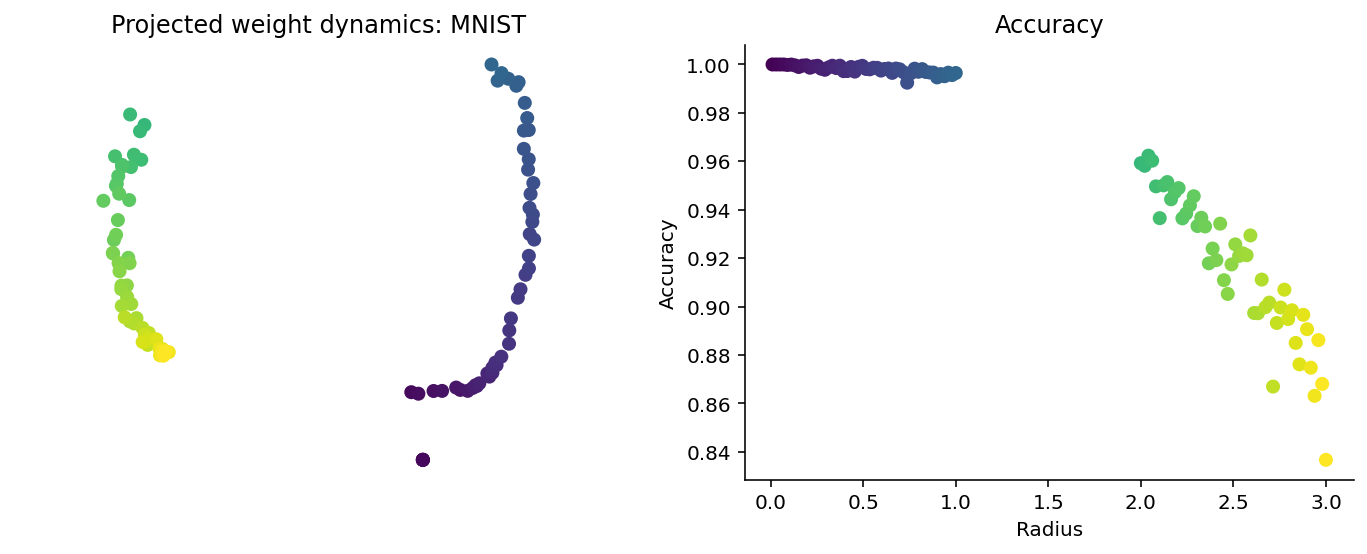

In [13]:
pca = PCA(n_components=2)
params_proj = pca.fit_transform(configs_params_flat)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title("Projected weight dynamics: MNIST")
ax[0].scatter(*params_proj.T, c=radii)
ax[0].tick_params(axis="both", labelleft=False, labelbottom=False)
ax[0].axis("equal")
ax[0].axis("off")


ax[1].set_title("Accuracy")
ax[1].scatter(radii, configs_accuracy, c=radii)
ax[1].set_xlabel("Radius")
ax[1].set_ylabel("Accuracy");

## Training weights

In [61]:
n_components = 60
pca = PCA(n_components=n_components)
params_proj = pca.fit_transform(configs_params_flat)

In [16]:
radii_dict = [{"radius": radius} for radius in radii]

In [17]:
n_train_subset = 6_000
subset_ix = pd.Series(y_train).sample(n_train_subset, random_state=314)
subset_ix = subset_ix.index.values
subset_ix

array([46242, 52277, 30471, ..., 18692,  3212,   220])

In [29]:
logger.add("training-weights-001-trench.log", rotation="5mb")
logger.warning("Initialising process")

2022-03-09 13:37:02.145 | WARNING  | __main__:<module>:2 - Initialising process


In [20]:
def processor(X, radius): return image.aug_np_wrapper(X, image.blur, radius=radius)
proc_class = gendist.processing.Factory(processor)
alpha = 0.0001
tx = optax.adam(learning_rate=alpha)

weights_model = gendist.models.MLPWeightsV1(n_components)
train_config = gendist.training.TrainingShift(weights_model, proc_class,
                                              gendist.training.make_multi_output_loss_func,
                                              tx)

In [31]:
weigths_trained = None

In [ ]:
batch_size = 10_000
num_epochs = 10
weights_trained, losses = train_config.train(key, X_train[subset_ix], params_proj,
                                             radii_dict, batch_size, num_epochs, logger, weigths_trained)

In [34]:
with open("weights-dynamics-trench.params", "wb") as f:
    bytes_params = serialization.to_bytes(weights_trained)
    f.write(bytes_params)

# Proxy zero-shot learning

In [68]:
radii_test = np.linspace(0.001, 3.0, 150)

In [21]:
with open("mnist-shift-params-220309.pkl", "rb") as f:
    output_elements = pickle.load(f)

    radii = output_elements["configs"]
    configs_params = output_elements["params"]
    configs_accuracy = output_elements["metric"]

with open("weights-dynamics.params", "rb") as f:
    weights_trained = weights_model.init(jax.random.PRNGKey(314), jnp.ones((1, 28 ** 2)))
    weights_trained = serialization.from_bytes(weights_trained, f.read())

In [69]:
logger.remove()

In [70]:
logger.add("projection-accuracy-trenches-v1.log", rotation="5mb")

2

In [71]:
X_test = np.array(mnist_test.data)
y_test = np.array(mnist_test.targets)

In [ ]:
ix = 4
accuracy_configs_learned = []
predicted_weights_array = []

for radius in tqdm(radii_test):
    x_test_shift = proc_class.process_single(X_test[ix], radius=radius)
    predicted_weights = weights_model.apply(weights_trained, x_test_shift.ravel())
    reconstructed_predicted_weights = pca.inverse_transform(predicted_weights)
    reconstructed_predicted_weights = fn_recontruct_params(reconstructed_predicted_weights)
    
    X_test_shift_ravel = proc_class(X_test, {"radius": radius})
    y_test_hat = model.apply(reconstructed_predicted_weights, X_test_shift_ravel)
    y_test_hat = y_test_hat.argmax(axis=1)
    
    accuracy_learned = (y_test_hat == y_test).mean()
    accuracy_configs_learned.append(accuracy_learned)
    
    predicted_weights_array.append(predicted_weights)
    
    logger.info(f"{radius=:0.4f} | {accuracy_learned=:0.4f}")

In [62]:
predicted_weights = weights_model.apply(weights_trained, x_test_shift.ravel())
reconstructed_predicted_weights = pca.inverse_transform(predicted_weights)

Text(0.5, 1.0, 'One-shot weight-prediction')

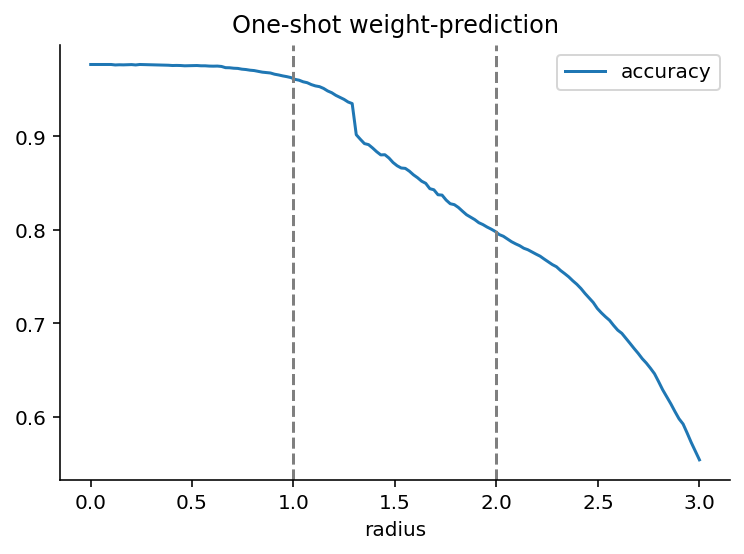

In [14]:
import re
with open("projection-accuracy-trenches.log", "r") as f:
    logs = f.read()
    
regexp = re.compile(r"radius=([0-9\.]+) \| accuracy_learned=([0-9\.]+)")

log_vals = []
for line in logs.split("\n")[:-1]:
    rad = regexp.search(line)[1]
    acc = regexp.search(line)[2]
    log_vals.append({"radius": float(rad), "accuracy": float(acc)})

log_df = pd.DataFrame(log_vals).set_index("radius")
log_df.plot()
plt.axvline(x=1.0, c="tab:gray", linestyle="--")
plt.axvline(x=2.0, c="tab:gray", linestyle="--")
plt.title("One-shot weight-prediction")

In [15]:
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

In [ ]:
pca_reconstruct = TSNE(n_components=2, perplexity=15, random_state=314)
pca_reconstruct = PCA(n_components=2)
predicted_matrix = np.r_[predicted_weights_array]

colors = ["tab:red" if 1 < radius < 2 else "tab:blue" for radius in radii_test]
plt.scatter(*pca_reconstruct.fit_transform(predicted_matrix).T, c=colors)
plt.colorbar()

In [122]:
import seaborn as sns

In [121]:
pca_reconstruct = PCA(n_components=1)
d1_reconstruct = pca_reconstruct.fit_transform(predicted_matrix)

/home/gerardoduran/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

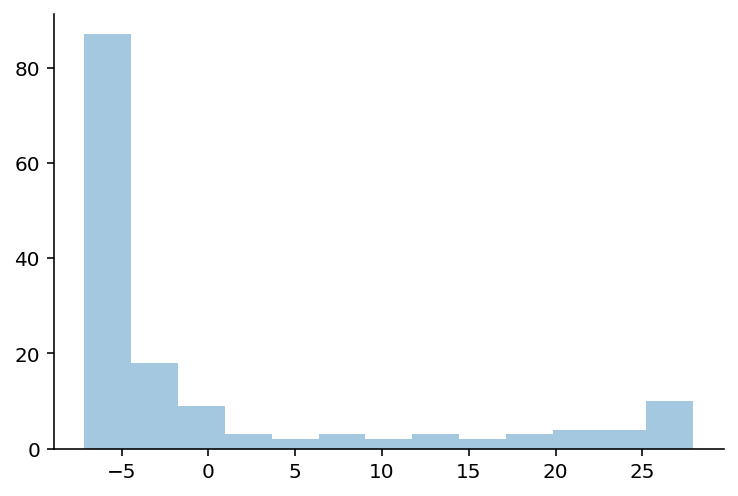

In [124]:
sns.distplot(d1_reconstruct, kde=False)

## ToDo:
1. Test on out-of-sample (trench part) of the model.